# Data Scaling and Modeling

After taking a closer look at the targets (see my [first notebook](https://www.kaggle.com/miykael/trends-exploration-of-the-targets)) and performing feature exploration and engineering (see my [second notebook](https://www.kaggle.com/miykael/trends-feature-exploration-engineering)), we are ready to train some models and perform some predictions.

With this notebook I want to show how I went from an average performing model to one in the top 25th, just by **(1)** using adapted targets, **(2)** use engineered features from the MRI maps and **(3)** fine tune the scaling of the different datasets. Especially the last point is something that went against my initial intuition.

In [1]:
import numpy as np
import pandas as pd
from os.path import join as opj
from tqdm.notebook import tqdm

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

# 1. Load targets and features

First things first, let's load the adapted targets and prepared feature datasets from my [second notebook](https://www.kaggle.com/miykael/trends-feature-exploration-engineering).

In [4]:
path = '/kaggle/input/trends-feature-exploration-engineering/datasets'

In [5]:
# Load target values and corresponding scaler
import joblib
scaler_targets = joblib.load(opj(path, 'targets_scaler.pkl'))

targets = pd.read_hdf(opj(path, 'targets.h5'))
targets.head()

,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,d21_rot,d22_rot
Id,,,,,,,
10001,0.546728,-1.899398,0.252044,0.508042,-0.101181,0.228396,-0.486307
10002,0.705146,-0.100839,0.716626,1.248698,0.511050,1.091555,-0.635136
10004,1.579096,0.117249,-0.161179,0.419738,0.905470,0.936611,0.244955
10005,1.218620,NaN,NaN,0.389779,1.634315,1.449477,0.712967
10007,-0.843261,-0.274512,0.544862,-0.697195,-1.459928,-1.458821,-0.514022


To load the feature matrix, let's write a function that performs the following steps:

1. Load the train and test set.
2. Select the target feature from the 5 (resp. 7) targets.
3. Centralize the corr_coef features to the median, which is about 0.689
4. Scale the four feature datasets (IC, FNC, intra and inter correlations) according to a scaler called `scale_values`. Before this scaler is applied, all feature within a dataset are scaled to the 90% value (i.e. top 10%). No centralization was applied.
5. Missing values are dropped.

In [6]:
def load_dataset_and_scale(target, dataset_id='merge', scale_values=[1, 1, 1, 1]):

    # Load dataset
    X_tr = pd.read_hdf(opj(path, '%s_train.h5' % dataset_id))
    X_te = pd.read_hdf(opj(path, '%s_test.h5' % dataset_id))

    # Specify target
    y = pd.read_hdf(opj(path, 'targets.h5'))
    y_tr = y.loc[X_tr.index, target]

    # Remove missing values
    missval = y_tr.isnull().values
    idx = ~missval
    X_tr = X_tr[idx]
    X_te = X_te
    y_tr = y_tr[idx]
    print('Removing %s missing values from target dataset.' % missval.sum())
    
    # Centralize corr_coef features
    median_offset = X_tr.iloc[:, X_tr.columns.str.contains('corr_coef')].median().mean()
    X_tr.iloc[:, X_tr.columns.str.contains('corr_coef')] -= median_offset
    X_te.iloc[:, X_te.columns.str.contains('corr_coef')] -= median_offset

    # Establish masks for different kinds of data
    mask_ids = []
    for m in ['IC_', '_vs_', 'corr_coef', '^c[0-9]+_c[0-9]+']:
        mask_ids.append(X_tr.columns.str.contains(m))
    mask_ids = np.array(mask_ids)

    # Data scaling
    for i, m in enumerate(mask_ids):

        if m.sum()==0:
            continue
        
        # Apply Scale
        scale_value = scale_values[i]
        unify_mask_scale = np.percentile(X_tr.iloc[:, m].abs(), 90)

        X_te.iloc[:, m] /= unify_mask_scale
        X_tr.iloc[:, m] /= unify_mask_scale
    
        X_te.iloc[:, m] *= scale_value
        X_tr.iloc[:, m] *= scale_value

    # Drop irrelevant measurements
    X_tr.dropna(axis=1, inplace=True)
    X_te.dropna(axis=1, inplace=True)
    
    # Drop duplicate rows
    X_tr = X_tr.T.drop_duplicates().T
    X_te = X_te.T.drop_duplicates().T
    
    print('Size of dataset (train/test): ', X_tr.shape, X_te.shape)
    
    X_tr = X_tr.values
    X_te = X_te.values
    y_tr = y_tr.values
    
    return X_tr, X_te, y_tr

# 2. Define scoring function and model parameters

Now that the data is ready, let's write a scoring function which **(1)** reverts the target adaptations (scaling and power transformation) and **(2)** makes sure that the predicted values are within the scope of the target values. The actual scoring function is the mean absolute error, as defined by the competition.

In [7]:
# Create scorer function
from sklearn.metrics import make_scorer
def model_metric(y_true, y_pred, scaler=None, tidx=0):
    
    # List of power transformations
    pow_age = 1.0
    pow_d1v1 = 1.5
    pow_d1v2 = 1.5
    pow_d2v1 = 1.5
    pow_d2v2 = 1.5
    pow_d21 = 1.5
    pow_d22 = 1.0

    powers = [pow_age, pow_d1v1, pow_d1v2, pow_d2v1, pow_d2v2, pow_d21, pow_d22]
    
    # Invert scaler
    t_true = scaler.inverse_transform(np.transpose([y_true] * 7))[:, tidx]
    t_pred = scaler.inverse_transform(np.transpose([y_pred] * 7))[:, tidx]
    
    # Assign closest value from training set
    unique_values = np.unique(t_true)
    for i, a in enumerate(t_pred):
        t_pred[i] = unique_values[np.argmin(np.abs(a-unique_values))]

    # Invert power transformation
    t_true = np.power(t_true, 1./powers[tidx])
    t_pred = np.power(t_pred, 1./powers[tidx])
    
    # Compute the score
    score = np.mean(np.sum(np.abs(t_true - t_pred), axis=0) / np.sum(t_true, axis=0))
    return score

Let's also write a function that generates the modeling pipeline, parameter grid and runs the `GridSearchCV` object.

In [8]:
def create_grid(model_metric, alphas=[0.1, 1, 10], estimator=None,
                cv=5, scaler_targets=None, tidx=0):

    # Create Pipeline
    pipeline = Pipeline([
        ('scaler', None),
        ('estimator', estimator),
    ])

    # Define parameter grid
    param_grid = [{'scaler': [None, RobustScaler()],
                   'estimator__alpha': alphas,
                  }]

    # Create grid search object
    f_scorer = make_scorer(model_metric, greater_is_better=False,
                           scaler=scaler_targets, tidx=tidx)
    grid = GridSearchCV(pipeline,
                        cv=cv,
                        param_grid=param_grid,
                        scoring=f_scorer,
                        return_train_score=True,
                        verbose=5,
                        n_jobs=-1)

    return grid

# 3. Initial data modeling approach (standard)

My first data modeling approach was rather standard. Take the data, apply a scaler, run a Ridge regression. So let's try this out, first only on the IC and FNC features and than once also with the feature engineered features.

## 3.1. Data modeling with 2 feature sets and RobustScaler

In [9]:
# Select the target (name and index)
target = 'age'
tidx = 0

# Let's select which features to use and how to scale them
scale_values = [1,        # IC features
                1,        # FNC features
                np.nan,   # intra features
                np.nan]   # inter features

X_tr, X_te, y_tr =  load_dataset_and_scale(target, scale_values=scale_values)

Removing 0 missing values from target dataset.
Size of dataset (train/test):  (5835, 1404) (5877, 1404)


In [10]:
# Define estimator
estimator = Ridge(tol=1e-3)

# Create grid search object
alphas = np.logspace(0, 4, 21)
grid = create_grid(model_metric, alphas=alphas, estimator=estimator,
                   cv=5, scaler_targets=scaler_targets, tidx=tidx)

# Run grid search
_ = grid.fit(X_tr, y_tr)

# Provide some insights into the models top performance
print('Dataset scales used: ', scale_values)
print("Best score at: %f using %s" % (grid.best_score_, grid.best_params_))

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  1.5min finished


Dataset scales used:  [1, 1, nan, nan]
Best score at: -0.144274 using {'estimator__alpha': 398.1071705534973, 'scaler': RobustScaler()}


Now to better understand what exactly happend, lets write some helper functions.

### Extract predictions and plot them

In [11]:
def extract_predictions(X_tr, X_te, grid, y_tr):

    # Store predictions in dictionary
    res = {}
    res['tr'] = grid.predict(X_tr)
    res['te'] = grid.predict(X_te)
    
    # Assign closest value from training set 
    unique_values = np.unique(y_tr)
    for t in ['tr', 'te']:
        for i, a in enumerate(res[t]):
            res[t][i] = unique_values[np.argmin(np.abs(a-unique_values))]

    return res['tr'], res['te']

In [12]:
# Extract the predictions for the training and the test set
pred_tr, pred_te = extract_predictions(X_tr, X_te, grid, y_tr)

In [13]:
def plot_predictions(pred_tr, pred_te, y_tr):

    # Plot prediction descrepancy on training and test set
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    ax[0].set_title('Prediction X_te: %s' % target)
    ax[0].plot(pred_te, '.', alpha=0.5, markersize=5)
    ax[0].plot(pred_tr, '.', alpha=0.3, markersize=5)
    ax[0].legend(['Train', 'Test'])
    ax[0].set_ylabel('target value')
    ax[0].set_xlabel('Sample')

    ax[1].set_title('Prediction X_tr: %s' % target)
    sns.regplot(x=pred_tr, y=y_tr, marker='.', ax=ax[1], scatter_kws={'s':10})
    ax[1].set_xlim([-3.5, 3.5])
    ax[1].set_ylim([-3.5, 3.5])
    ax[1].set_ylabel('True value')
    ax[1].set_xlabel('Predicted value')
    
    plt.show()

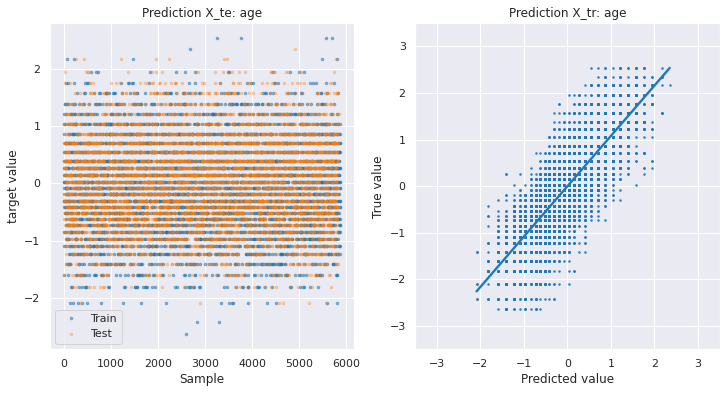

In [14]:
# Plot the predictions with respect to each other and to the target
plot_predictions(pred_tr, pred_te, y_tr)

The **left** figure shows the individual prediction values (in y direction) in a sequential fashion next to each other (i.e. feature 0 to 5835 = `X_tr.shape[1]`). In blue are the values from the training set, in orange the one from the test set.

In the **right** figure, we can see the relationship between the predicted and the true target values.

### Collect information about grid point performance and plot them

In [15]:
def create_df_pred(grid):

    # Store grid search parameters and outcomes in dataframe
    df_pred = pd.DataFrame(grid.cv_results_)
    columns = [c for c in df_pred.columns if 'time' not in c
               and 'split' not in c
               and 'rank' not in c
               and c!='params']
    df_pred = df_pred[columns].sort_values('mean_test_score', ascending=False)
    df_pred['param_estimator__alpha'] = df_pred['param_estimator__alpha'].astype('float')
    df_pred['param_scaler'] = df_pred['param_scaler'].astype('str')
    
    return df_pred

In [16]:
# Creates dataframe about grid point's performance
df_pred = create_df_pred(grid).sort_values('mean_test_score')
df_pred.head()

,param_estimator__alpha,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
40,10000.000000,None,-0.197533,0.005490,-0.195620,0.001243
38,6309.573445,None,-0.192386,0.005070,-0.189375,0.000996
36,3981.071706,None,-0.186320,0.004834,-0.182696,0.000882
34,2511.886432,None,-0.180085,0.004630,-0.175454,0.000743
32,1584.893192,None,-0.173885,0.004160,-0.168054,0.000730


In [17]:
def plot_hyperparam_fitting(df_pred):

    # Plot the model fit information
    for s in df_pred['param_scaler'].unique():

        df_plot = df_pred[np.prod([df_pred['param_scaler']==s],
                                  axis=0).astype('bool')]

        df_plot = df_plot.sort_values('param_estimator__alpha')

        # Extract relevant modelling metrics
        train_scores = df_plot['mean_train_score']
        valid_scores = df_plot['mean_test_score']
        std_tr = df_plot['std_train_score']
        std_va = df_plot['std_test_score']

        plt.figure(figsize=(12, 4))
        alphas = df_plot['param_estimator__alpha']
        plt.semilogx(alphas, train_scores, label='Training Set')
        plt.semilogx(alphas, valid_scores, label='Validation Set')

        # Add marker and text for best score
        max_id = np.argmax(valid_scores)
        x_pos = alphas.iloc[max_id]
        y_pos = valid_scores.iloc[max_id]
        txt = '{:0.4f}'.format(y_pos)
        plt.scatter(x_pos, y_pos, marker='x', c='red', zorder=10)
        plt.text(x_pos, y_pos, txt, fontdict={'size': 18})

        # Quantify variance with ±std curves
        plt.fill_between(alphas, train_scores-std_tr, train_scores+std_tr, alpha=0.3)
        plt.fill_between(alphas, valid_scores-std_va, valid_scores+std_va, alpha=0.3)
        plt.ylabel('Performance metric')
        plt.xlabel('Model parameter')

        # Adjust x-lim, y-lim, add legend and adjust layout
        plt.legend()
        plt.title('Scaler: %s' % s)
        plt.show()

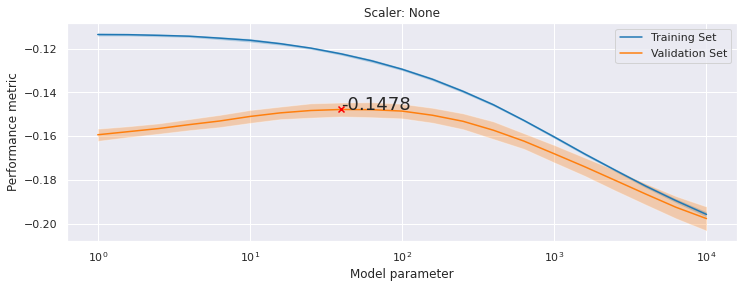

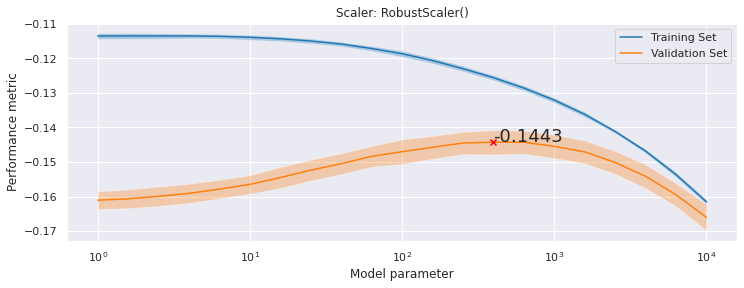

In [18]:
# Plot prediction behaviour
plot_hyperparam_fitting(df_pred)

## Observation 1

As we can see, the unviersally scaled (i.e. using `RobustScaler()`) data leads to better predictions. Let's see what happens if we include all 4 feature sets.

## 3.2. Data modeling with 4 feature sets and RobustScaler

In [19]:
# Select the target (name and index)
target = 'age'
tidx = 0

# Let's select which features to use and how to scale them
scale_values = [1,        # IC features
                1,        # FNC features
                1,        # intra features
                1]        # inter features

X_tr, X_te, y_tr =  load_dataset_and_scale(target, scale_values=scale_values)

Removing 0 missing values from target dataset.
Size of dataset (train/test):  (5835, 2835) (5877, 2835)


In [20]:
# Define estimator
estimator = Ridge(tol=1e-3)

# Create grid search object
alphas = np.logspace(1, 5, 21)
grid = create_grid(model_metric, alphas=alphas, estimator=estimator,
                   cv=5, scaler_targets=scaler_targets, tidx=tidx)

# Run grid search
_ = grid.fit(X_tr, y_tr)

# Provide some insights into the models top performance
print('Dataset scales used: ', scale_values)
print("Best score at: %f using %s" % (grid.best_score_, grid.best_params_))

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  4.8min finished


Dataset scales used:  [1, 1, 1, 1]
Best score at: -0.145916 using {'estimator__alpha': 1584.893192461114, 'scaler': RobustScaler()}


In [21]:
# Extract the predictions for the training and the test set
pred_tr, pred_te = extract_predictions(X_tr, X_te, grid, y_tr)

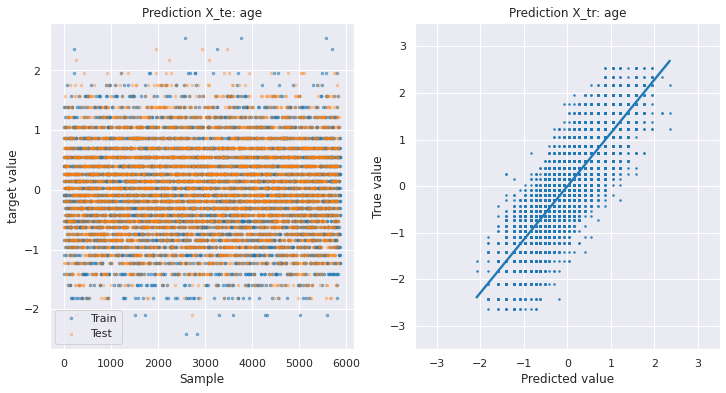

In [22]:
# Plot the predictions with respect to each other and to the target
plot_predictions(pred_tr, pred_te, y_tr)

In [23]:
# Creates dataframe about grid point's performance
df_pred = create_df_pred(grid).sort_values('mean_test_score', ascending=False)
df_pred.head()

,param_estimator__alpha,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
23,1584.893192,RobustScaler(),-0.145916,0.002962,-0.115349,0.000509
21,1000.000000,RobustScaler(),-0.146709,0.002689,-0.109961,0.000311
25,2511.886432,RobustScaler(),-0.146777,0.002807,-0.121770,0.000525
19,630.957344,RobustScaler(),-0.148569,0.002842,-0.105187,0.000276
27,3981.071706,RobustScaler(),-0.148805,0.002957,-0.128847,0.000601


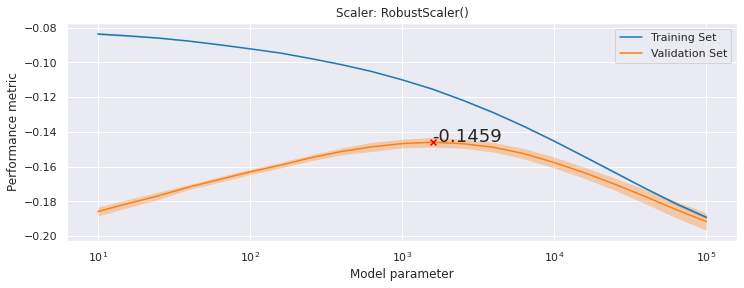

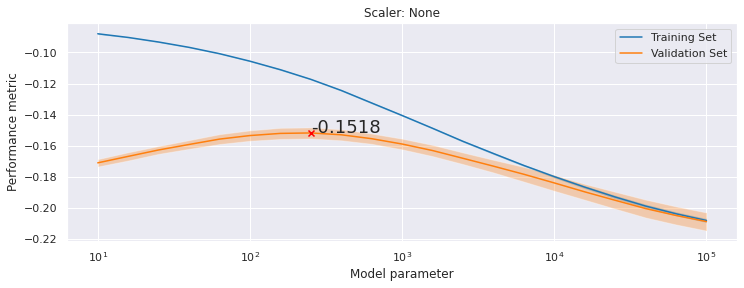

In [24]:
# Plot prediction behaviour
plot_hyperparam_fitting(df_pred)

## Observation 2

Hmm... things seem to have gotten worse. It's at that time that I've explored multiple other models. SVR (linear/rbf), lasso, elastinet, SGD, KNN, RandomForests, Neural networks, etc. Nothing seems to have help.

# 4. Manual data scaling

Going against my initial intuition, I've tried the scaling of the FNC features. I was curious why some people scaled with a factor of 500, others with 400, 600 or 300. My solution to this conundrum was, let's triangulate the optimal scaling.

The task was straight forward and very iterative. Let's try different values within the variable...

```python
scale_values = [1,        # IC features
                1,        # FNC features
                1,        # intra features
                1]        # inter features

```

and see if this improves the modeling. As much as I can observe, using different scales means also moving the optimal "alpha peak" around. It's kind of like a summazion of different waves where you try to stack the peaks. Changing the scales, changes the peaks location (not necessarily the hight) on the x axis. Problem here is clearly, everytime you add another feature set, the regularization term might shift heavily.

Nonetheless, this path proved to be fruitful. So let's see the effect. Again, finding the right values, was a triangulation/iterative approach.

But before we start, let's package this all into a function.

In [25]:
def run_prediction(model_metric, estimator=None, alphas=[0.1, 1, 10], cv=5,
                   scaler_targets=None, target='age', tidx=0, scale_values=None):
    
    # Extract dataset
    X_tr, X_te, y_tr = load_dataset_and_scale(target, scale_values=scale_values)
    
    # Create grid search object
    grid = create_grid(model_metric, alphas=alphas, estimator=estimator,
                       cv=cv, scaler_targets=scaler_targets, tidx=tidx)
    
    # Run grid search
    _ = grid.fit(X_tr, y_tr)
    
    # Provide some insights into the models top performance
    print('Dataset scales used: ', scale_values)
    print("Best score at: %f using %s" % (grid.best_score_, grid.best_params_))

    # Extract the predictions for the training and the test set
    pred_tr, pred_te = extract_predictions(X_tr, X_te, grid, y_tr)

    # Plot the predictions with respect to each other and to the target
    plot_predictions(pred_tr, pred_te, y_tr)

    # Creates dataframe about grid point's performance
    df_pred = create_df_pred(grid)
    display(df_pred.sort_values('mean_test_score', ascending=False).head())

    # Plot prediction behaviour
    plot_hyperparam_fitting(df_pred)
    
    return df_pred, pred_tr, pred_te, grid, y_tr

## 4.1. Data modeling with 2 manually scaled feature sets

In [26]:
# Select the target (name and index)
target = 'age'
tidx = 0

In [27]:
# Let's select which features to use and how to scale them
scale_values = [0.25,     # Feature: IC
                0.04,     # Feature: FNC
                np.nan,   # Feature: Intra Corr
                np.nan,   # Feature: Inter Corr
               ]

In [28]:
# Define model parameters
estimator = Ridge(tol=1e-3)
alphas = np.logspace(-2, 4, 31)
cv = 5

Removing 0 missing values from target dataset.
Size of dataset (train/test):  (5835, 1404) (5877, 1404)
Fitting 5 folds for each of 62 candidates, totalling 310 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:  2.2min finished


Dataset scales used:  [0.25, 0.04, nan, nan]
Best score at: -0.143034 using {'estimator__alpha': 0.3981071705534973, 'scaler': None}


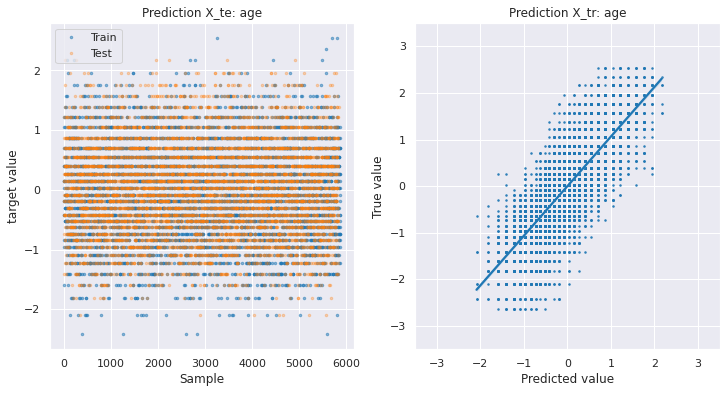

,param_estimator__alpha,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
16,0.398107,None,-0.143034,0.003663,-0.129216,0.001020
14,0.251189,None,-0.143096,0.003735,-0.126678,0.000893
18,0.630957,None,-0.143133,0.003772,-0.131625,0.001027
12,0.158489,None,-0.143576,0.003472,-0.124480,0.000838
20,1.000000,None,-0.143908,0.003755,-0.134459,0.000831


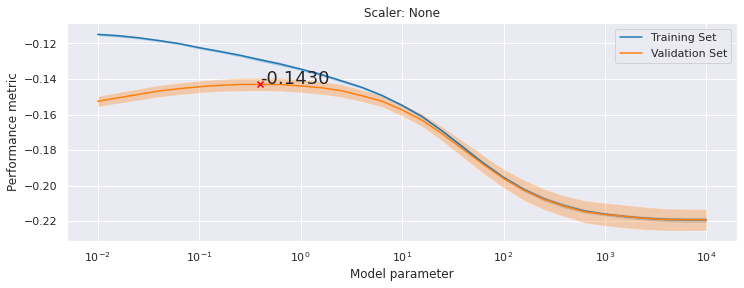

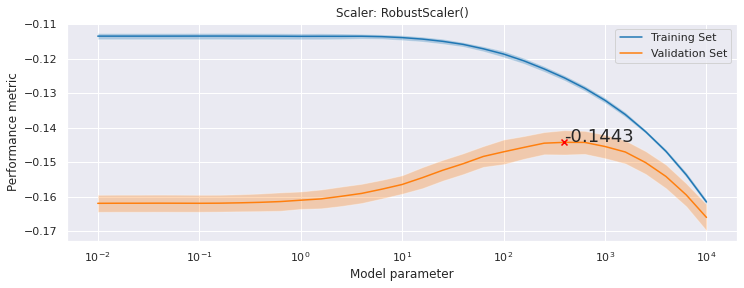

In [29]:
df_pred, pred_tr, pred_te, grid, y_tr = run_prediction(
    model_metric, estimator=estimator, alphas=alphas, cv=cv,
    scaler_targets=scaler_targets, target=target, tidx=tidx,
    scale_values=scale_values)

## Observation 3

As we saw in other scaling approaches (e.g. scaling with a factor of 500), we can see that the results improved and are now better than ones with the `RobustScaler()`. Let's see what the other two feature sets bring to the table.

## 4.2. Data modeling with 3 manually scaled feature sets

In [30]:
# Select the target (name and index)
target = 'age'
tidx = 0

In [31]:
# Let's select which features to use and how to scale them
scale_values = [0.25,     # Feature: IC
                0.04,     # Feature: FNC
                0.087,    # Feature: Intra Corr
                np.nan,   # Feature: Inter Corr
               ]

In [32]:
# Define model parameters
estimator = Ridge(tol=1e-3)
alphas = np.logspace(-2, 4, 31)
cv = 5

Removing 0 missing values from target dataset.
Size of dataset (train/test):  (5835, 1457) (5877, 1457)
Fitting 5 folds for each of 62 candidates, totalling 310 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:  2.3min finished


Dataset scales used:  [0.25, 0.04, 0.087, nan]
Best score at: -0.140785 using {'estimator__alpha': 0.3981071705534973, 'scaler': None}


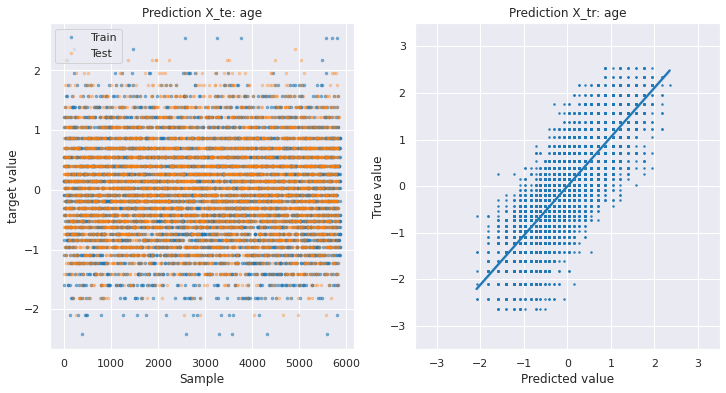

,param_estimator__alpha,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
16,0.398107,None,-0.140785,0.002992,-0.126263,0.000982
18,0.630957,None,-0.140884,0.003410,-0.128680,0.000947
14,0.251189,None,-0.141119,0.002970,-0.123789,0.000814
20,1.000000,None,-0.141472,0.003390,-0.131298,0.001051
12,0.158489,None,-0.141842,0.003147,-0.121457,0.000824


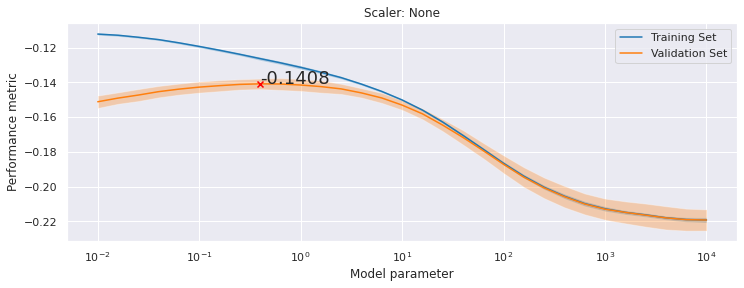

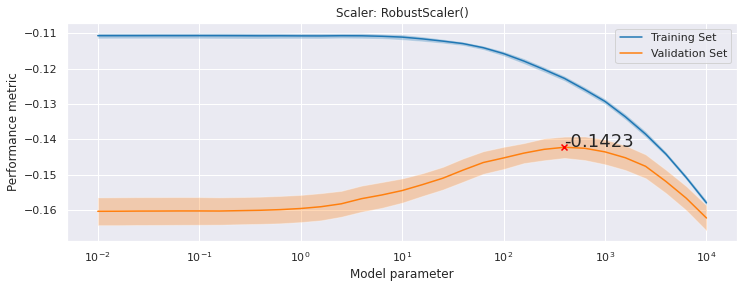

In [33]:
df_pred, pred_tr, pred_te, grid, y_tr = run_prediction(
    model_metric, estimator=estimator, alphas=alphas, cv=cv,
    scaler_targets=scaler_targets, target=target, tidx=tidx,
    scale_values=scale_values)

## 4.3. Data modeling with 4 manually scaled feature sets

In [34]:
# Select the target (name and index)
target = 'age'
tidx = 0

In [35]:
# Let's select which features to use and how to scale them
scale_values = [0.25,     # Feature: IC
                0.04,     # Feature: FNC
                0.087,    # Feature: Intra Corr
                0.025,    # Feature: Inter Corr
               ]

In [36]:
# Define model parameters
estimator = Ridge(tol=1e-3)
alphas = np.logspace(-2, 4, 31)
cv = 5

Removing 0 missing values from target dataset.
Size of dataset (train/test):  (5835, 2835) (5877, 2835)
Fitting 5 folds for each of 62 candidates, totalling 310 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:  6.6min finished


Dataset scales used:  [0.25, 0.04, 0.087, 0.025]
Best score at: -0.138748 using {'estimator__alpha': 0.6309573444801934, 'scaler': None}


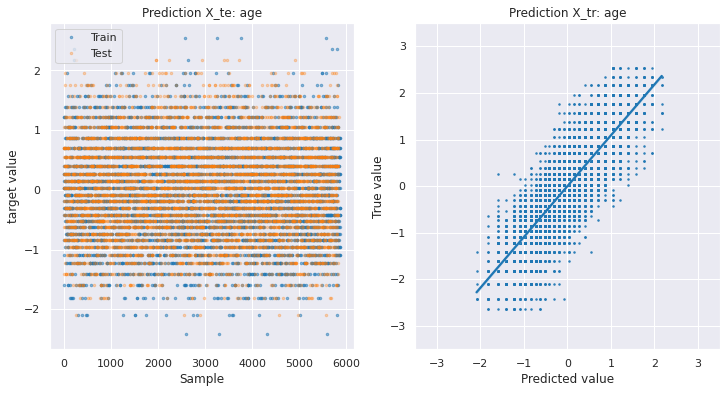

,param_estimator__alpha,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
18,0.630957,None,-0.138748,0.002507,-0.118569,0.000529
16,0.398107,None,-0.139333,0.002343,-0.113684,0.000516
20,1.000000,None,-0.139398,0.002769,-0.123102,0.000619
22,1.584893,None,-0.140308,0.002768,-0.127688,0.000777
14,0.251189,None,-0.140506,0.002284,-0.109177,0.000387


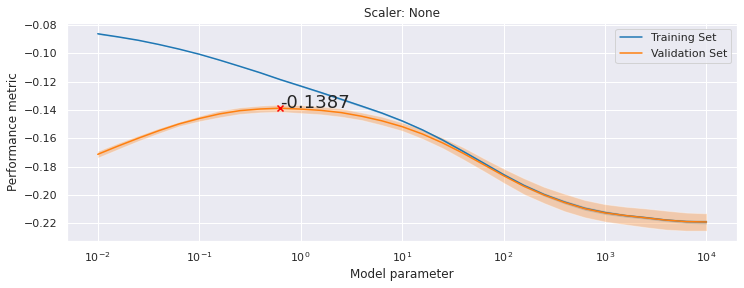

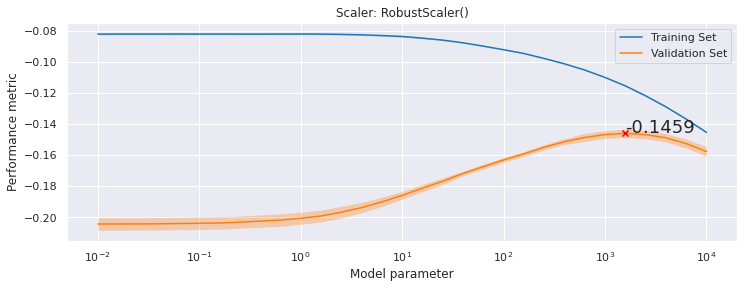

In [37]:
df_pred, pred_tr, pred_te, grid, y_tr = run_prediction(
    model_metric, estimator=estimator, alphas=alphas, cv=cv,
    scaler_targets=scaler_targets, target=target, tidx=tidx,
    scale_values=scale_values)

## Observartion 4

As we can see, using these 4 feature datasets with manually scaled properties, we can reduce the mean absolute error for age quiet a bit. However, using a standard `RobustScaler` approach, this advantage gets lost and we are worse off than before.

# 5. Compute predictions for all 5 targets using Ridge

In [38]:
# Collect test predictions
predictions_ridge = {}

# Save predictions for age in output variable
predictions_ridge[target] = pred_te

## 5.1. Predicting `domain1_var1` using Ridge

In [39]:
# Select the target (name and index)
target = 'domain1_var1'
tidx = 1

In [40]:
# Let's select which features to use and how to scale them
scale_values = [0.25,    # Feature: IC
                0.01,    # Feature: FNC
                0.032,   # Feature: Intra Corr
                0.019,   # Feature: Inter Corr
               ]

In [41]:
# Define model parameters
estimator = Ridge(tol=1e-3)
alphas = np.logspace(-1, 5, 31)
cv = 5

Removing 437 missing values from target dataset.
Size of dataset (train/test):  (5398, 2835) (5877, 2835)
Fitting 5 folds for each of 62 candidates, totalling 310 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:  6.5min finished


Dataset scales used:  [0.25, 0.01, 0.032, 0.019]
Best score at: -0.150528 using {'estimator__alpha': 1.0, 'scaler': None}


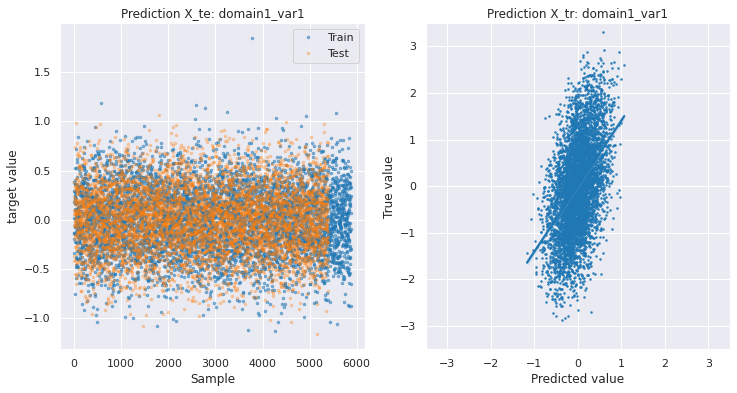

,param_estimator__alpha,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
10,1.000000,None,-0.150528,0.001607,-0.141972,0.000350
12,1.584893,None,-0.150556,0.001689,-0.144331,0.000367
14,2.511886,None,-0.150762,0.001784,-0.146289,0.000396
8,0.630957,None,-0.150778,0.001536,-0.139176,0.000340
16,3.981072,None,-0.151082,0.001921,-0.147913,0.000433


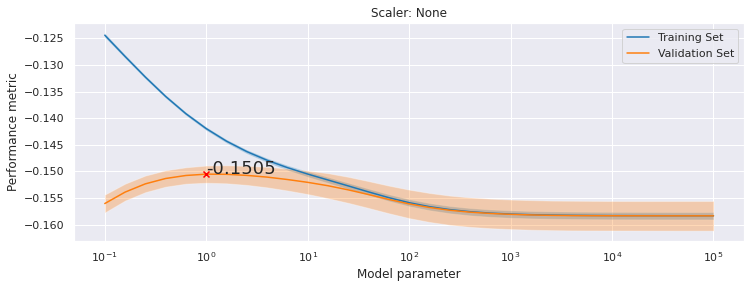

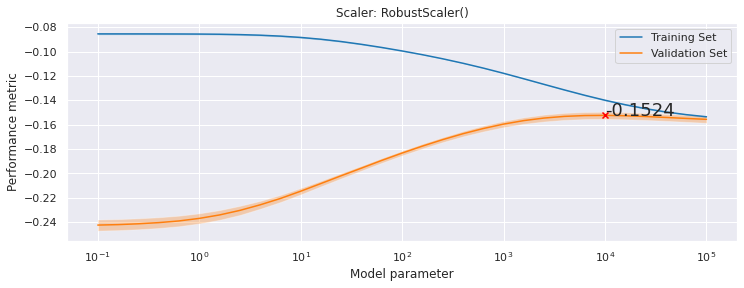

In [42]:
df_pred, pred_tr, pred_te, grid, y_tr = run_prediction(
    model_metric, estimator=estimator, alphas=alphas, cv=cv,
    scaler_targets=scaler_targets, target=target, tidx=tidx,
    scale_values=scale_values)

In [43]:
# Save predictions for domain1_var1 in output variable
predictions_ridge[target] = pred_te

## 5.2. Predicting `domain1_var2` using Ridge

In [44]:
# Select the target (name and index)
target = 'domain1_var2'
tidx = 2

In [45]:
# Let's select which features to use and how to scale them
scale_values = [0.121,   # Feature: IC
                0.019,   # Feature: FNC
                0.032,   # Feature: Intra Corr
                0.025,   # Feature: Inter Corr
               ]

In [46]:
# Define model parameters
estimator = Ridge(tol=1e-3)
alphas = np.logspace(-1, 5, 31)
cv = 5

Removing 437 missing values from target dataset.
Size of dataset (train/test):  (5398, 2835) (5877, 2835)
Fitting 5 folds for each of 62 candidates, totalling 310 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:  6.3min finished


Dataset scales used:  [0.121, 0.019, 0.032, 0.025]
Best score at: -0.150540 using {'estimator__alpha': 3.981071705534973, 'scaler': None}


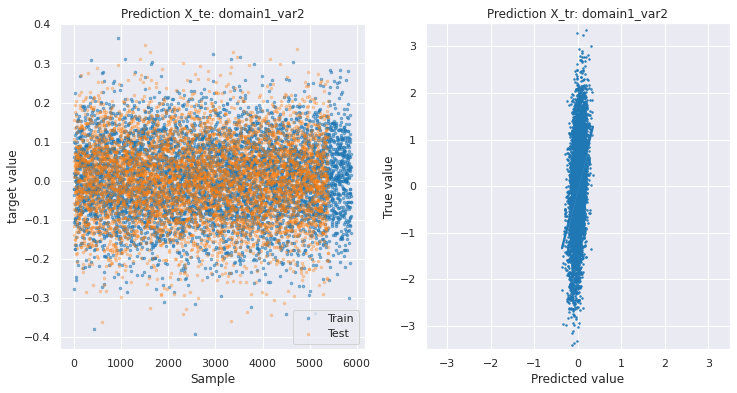

,param_estimator__alpha,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
16,3.981072,None,-0.150540,0.003590,-0.146103,0.000902
14,2.511886,None,-0.150558,0.003600,-0.144224,0.000905
18,6.309573,None,-0.150599,0.003555,-0.147536,0.000895
57,39810.717055,RobustScaler(),-0.150640,0.003505,-0.146593,0.000875
55,25118.864315,RobustScaler(),-0.150664,0.003523,-0.144794,0.000885


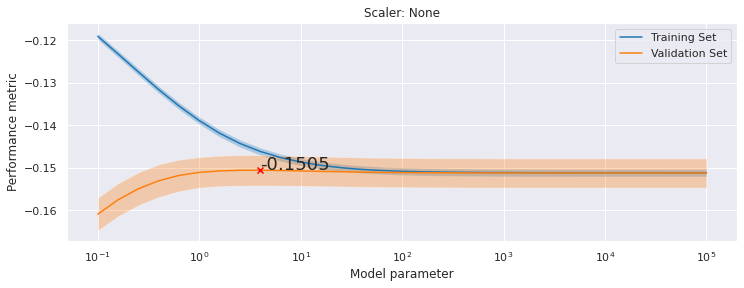

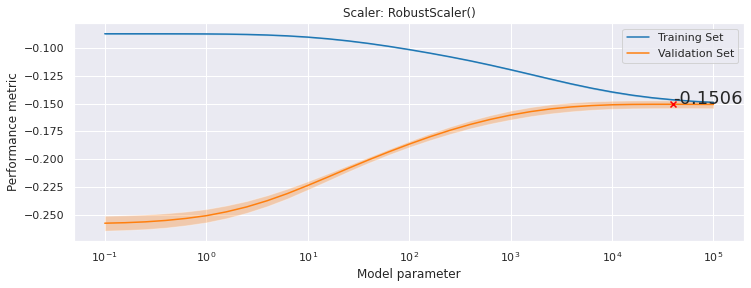

In [47]:
df_pred, pred_tr, pred_te, grid, y_tr = run_prediction(
    model_metric, estimator=estimator, alphas=alphas, cv=cv,
    scaler_targets=scaler_targets, target=target, tidx=tidx,
    scale_values=scale_values)

In [48]:
# Save predictions for domain1_var2 in output variable
predictions_ridge[target] = pred_te

## 5.3. Predicting `domain2_var1` using Ridge

In [49]:
# Select the target (name and index)
target = 'domain2_var1'
tidx = 3

In [50]:
# Let's select which features to use and how to scale them
scale_values = [0.25,    # Feature: IC
                0.008,   # Feature: FNC
                0.012,   # Feature: Intra Corr
                0.012,   # Feature: Inter Corr
               ]

In [51]:
# Define model parameters
estimator = Ridge(tol=1e-3)
alphas = np.logspace(-1, 5, 31)
cv = 5

Removing 39 missing values from target dataset.
Size of dataset (train/test):  (5796, 2835) (5877, 2835)
Fitting 5 folds for each of 62 candidates, totalling 310 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:  6.9min finished


Dataset scales used:  [0.25, 0.008, 0.012, 0.012]
Best score at: -0.180513 using {'estimator__alpha': 0.6309573444801934, 'scaler': None}


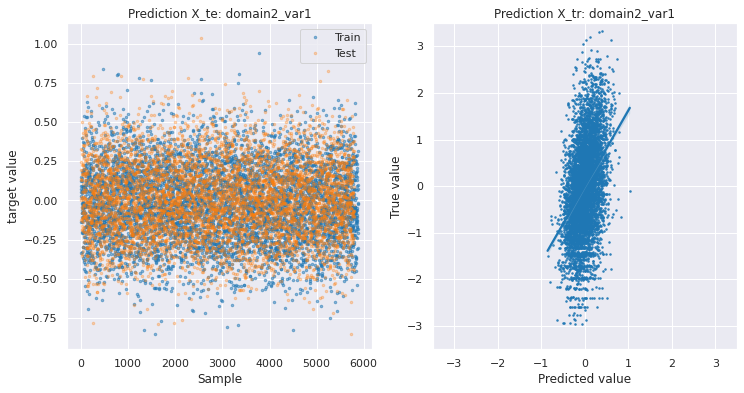

,param_estimator__alpha,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
8,0.630957,None,-0.180513,0.004124,-0.172802,0.000951
10,1.000000,None,-0.180606,0.004226,-0.175109,0.000980
6,0.398107,None,-0.180636,0.003977,-0.169966,0.000909
12,1.584893,None,-0.180864,0.004278,-0.176968,0.001011
4,0.251189,None,-0.181109,0.003806,-0.166562,0.000854


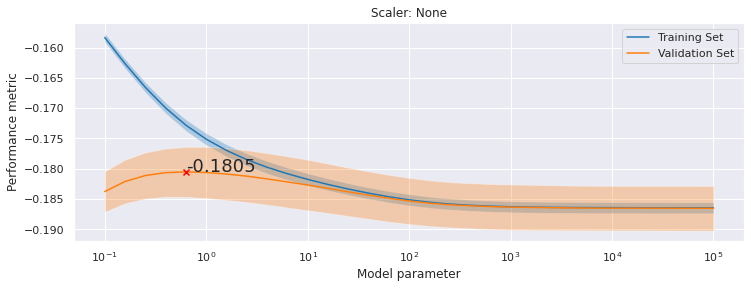

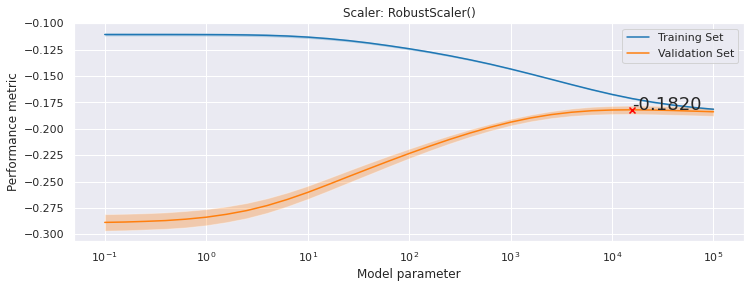

In [52]:
df_pred, pred_tr, pred_te, grid, y_tr = run_prediction(
    model_metric, estimator=estimator, alphas=alphas, cv=cv,
    scaler_targets=scaler_targets, target=target, tidx=tidx,
    scale_values=scale_values)

In [53]:
# Save predictions for domain2_var1 in output variable
predictions_ridge[target] = pred_te

## 5.4. Predicting `domain2_var2` using Ridge

In [54]:
# Select the target (name and index)
target = 'domain2_var2'
tidx = 4

In [55]:
# Let's select which features to use and how to scale them
scale_values = [0.261,   # Feature: IC
                0.025,   # Feature: FNC
                0.052,   # Feature: Intra Corr
                0.022,   # Feature: Inter Corr
               ]

In [56]:
# Define model parameters
estimator = Ridge(tol=1e-3)
alphas = np.logspace(-1, 5, 31)
cv = 5

Removing 39 missing values from target dataset.
Size of dataset (train/test):  (5796, 2835) (5877, 2835)
Fitting 5 folds for each of 62 candidates, totalling 310 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 310 out of 310 | elapsed:  6.9min finished


Dataset scales used:  [0.261, 0.025, 0.052, 0.022]
Best score at: -0.175010 using {'estimator__alpha': 3.981071705534973, 'scaler': None}


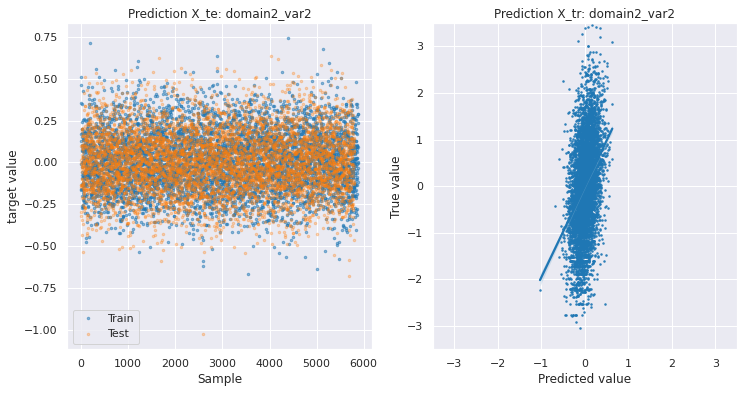

,param_estimator__alpha,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
16,3.981072,None,-0.175010,0.003009,-0.168859,0.000815
14,2.511886,None,-0.175082,0.003052,-0.166547,0.000847
18,6.309573,None,-0.175176,0.002999,-0.170801,0.000780
12,1.584893,None,-0.175467,0.003118,-0.163804,0.000883
20,10.000000,None,-0.175478,0.003004,-0.172417,0.000756


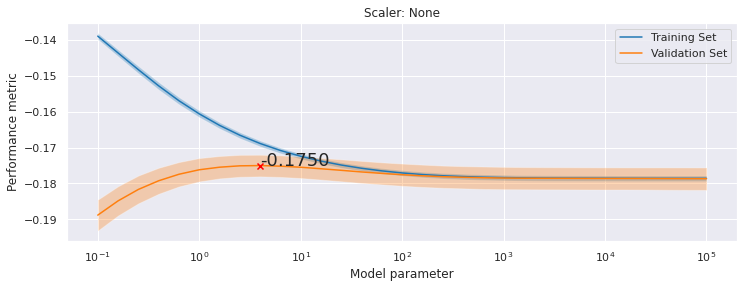

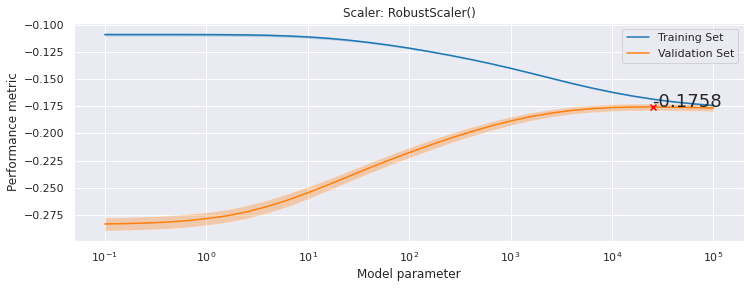

In [57]:
df_pred, pred_tr, pred_te, grid, y_tr = run_prediction(
    model_metric, estimator=estimator, alphas=alphas, cv=cv,
    scaler_targets=scaler_targets, target=target, tidx=tidx,
    scale_values=scale_values)

In [58]:
# Save predictions for domain2_var2 in output variable
predictions_ridge[target] = pred_te

## Conclusion 1

Using the manual scaling approach, together with the four feature datastes is very powerful, but mostly only helps with the prediction of `age`.

It is possible to increase the scores slightly, by focusing in on the grid space and optimize the alpha value (as well as the manual scaling factor) more precisely, but the risk is clearly also there for overfitting.

Increasing the number of folds (i.e. `cv`) helps with some targets and worsens other. But the generalization probably improves nonetheless.

# 6. Compute prediction for all 5 targets using SVR (rbf)

As other's have mentioned in the discussions, Ridge and SVR seem to be very suited to predict the target values. For this reason, let's do the same thing as we did above, but this time with an SVR estimator, using an rbf kernel.

The only thing we need to adapt to make this work is the following three functions.

**Note**: To reduce computation time, we will remove the `RobustScaler` from the grid search.

In [59]:
def create_grid(model_metric, alphas=[0.1, 1, 10], estimator=None,
                cv=5, scaler_targets=None, tidx=0):

    # Create Pipeline
    pipeline = Pipeline([
        ('estimator', estimator),
    ])

    # Define parameter grid
    param_grid = [{'estimator__C': alphas}]

    # Create grid search object
    f_scorer = make_scorer(model_metric, greater_is_better=False,
                           scaler=scaler_targets, tidx=tidx)
    grid = GridSearchCV(pipeline,
                        cv=cv,
                        param_grid=param_grid,
                        scoring=f_scorer,
                        return_train_score=True,
                        verbose=5,
                        n_jobs=-1)

    return grid

In [60]:
def create_df_pred(grid):

    # Store grid search parameters and outcomes in dataframe
    df_pred = pd.DataFrame(grid.cv_results_)
    columns = [c for c in df_pred.columns if 'time' not in c
               and 'split' not in c
               and 'rank' not in c
               and c!='params']
    df_pred = df_pred[columns].sort_values('mean_test_score', ascending=False)
    df_pred['param_estimator__C'] = df_pred['param_estimator__C'].astype('float')

    return df_pred

In [61]:
def plot_hyperparam_fitting(df_pred):

    # Plot the model fit information
    df_plot = df_pred.copy()

    df_plot = df_plot.sort_values('param_estimator__C')

    # Extract relevant modelling metrics
    train_scores = df_plot['mean_train_score']
    valid_scores = df_plot['mean_test_score']
    std_tr = df_plot['std_train_score']
    std_va = df_plot['std_test_score']

    plt.figure(figsize=(12, 4))
    Cs = df_plot['param_estimator__C']
    plt.semilogx(Cs, train_scores, label='Training Set')
    plt.semilogx(Cs, valid_scores, label='Validation Set')

    # Add marker and text for best score
    max_id = np.argmax(valid_scores)
    x_pos = Cs.iloc[max_id]
    y_pos = valid_scores.iloc[max_id]
    txt = '{:0.4f}'.format(y_pos)
    plt.scatter(x_pos, y_pos, marker='x', c='red', zorder=10)
    plt.text(x_pos, y_pos, txt, fontdict={'size': 18})

    # Quantify variance with ±std curves
    plt.fill_between(Cs, train_scores-std_tr, train_scores+std_tr, alpha=0.3)
    plt.fill_between(Cs, valid_scores-std_va, valid_scores+std_va, alpha=0.3)
    plt.ylabel('Performance metric')
    plt.xlabel('Model parameter')

    # Adjust x-lim, y-lim, add legend and adjust layout
    plt.legend()
    plt.show()

## 6.1. Predicting `age` using SVR(rbf)

In [62]:
# Select the target (name and index)
target = 'age'
tidx = 0

In [63]:
# Let's select which features to use and how to scale them
scale_values = [0.25,      # Feature: IC
                0.015,     # Feature: FNC
                0.042,     # Feature: Intra Corr
                0.014,     # Feature: Inter Corr
               ]

In [64]:
# Define model parameters
estimator = SVR(gamma='scale', epsilon=0.2, tol=1e-3, max_iter=5000)
Cs = np.logspace(-1, 1, 11)
cv = 5

Removing 0 missing values from target dataset.
Size of dataset (train/test):  (5835, 2835) (5877, 2835)
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed: 44.2min finished
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Dataset scales used:  [0.25, 0.015, 0.042, 0.014]
Best score at: -0.138640 using {'estimator__C': 2.511886431509581}


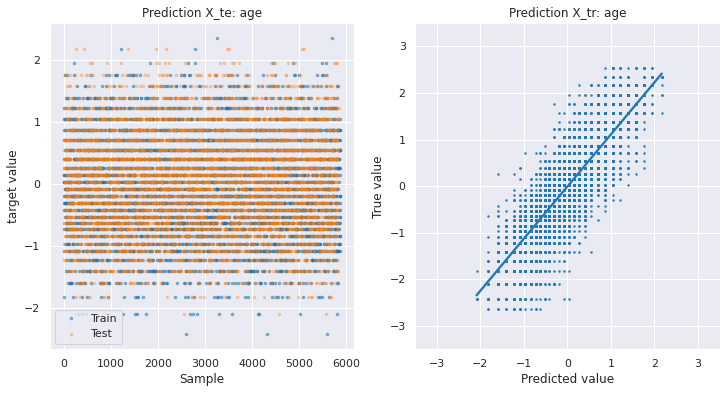

,param_estimator__C,mean_test_score,std_test_score,mean_train_score,std_train_score
7,2.511886,-0.138640,0.002286,-0.104261,0.000586
8,3.981072,-0.138737,0.001853,-0.094382,0.000464
6,1.584893,-0.138939,0.002355,-0.113331,0.000489
5,1.000000,-0.139677,0.002607,-0.120955,0.000694
9,6.309573,-0.140698,0.002019,-0.084100,0.000270


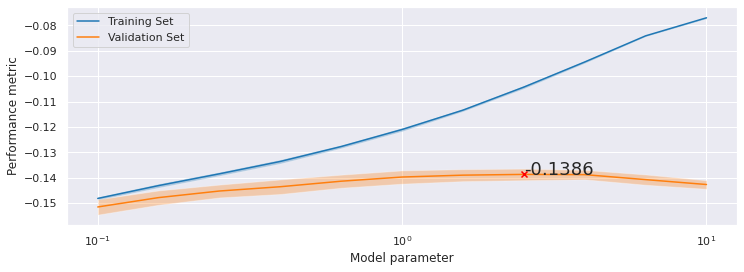

In [65]:
df_pred, pred_tr, pred_te, grid, y_tr = run_prediction(
    model_metric, estimator=estimator, alphas=Cs, cv=cv,
    scaler_targets=scaler_targets, target=target, tidx=tidx,
    scale_values=scale_values)

In [66]:
# Collect test predictions
predictions_svr = {}

# Save predictions for age in output variable
predictions_svr[target] = pred_te

## 6.2. Predicting `domain1_var1` using SVR(rbf)

In [67]:
# Select the target (name and index)
target = 'domain1_var1'
tidx = 1

In [68]:
# Let's select which features to use and how to scale them
scale_values = [0.25,      # Feature: IC
                0.012,     # Feature: FNC
                0.032,     # Feature: Intra Corr
                0.018,     # Feature: Inter Corr
               ]

In [69]:
# Define model parameters
estimator = SVR(gamma='scale', epsilon=0.2, tol=1e-3, max_iter=5000)
Cs = np.logspace(-1, 1, 11)
cv = 5

Removing 437 missing values from target dataset.
Size of dataset (train/test):  (5398, 2835) (5877, 2835)
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed: 42.6min finished


Dataset scales used:  [0.25, 0.012, 0.032, 0.018]
Best score at: -0.150759 using {'estimator__C': 0.3981071705534973}


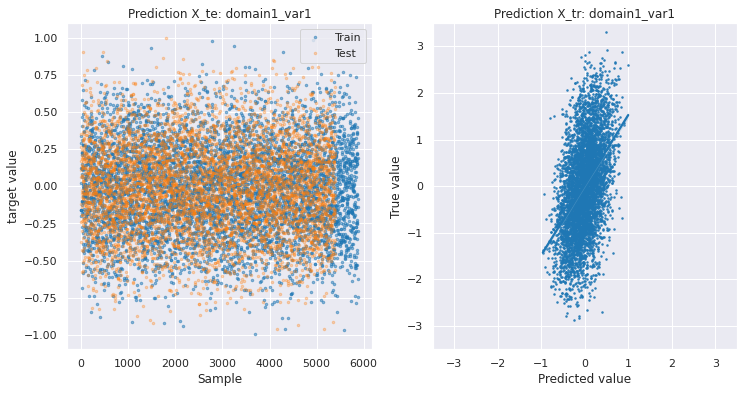

,param_estimator__C,mean_test_score,std_test_score,mean_train_score,std_train_score
3,0.398107,-0.150759,0.001778,-0.141425,0.000331
4,0.630957,-0.150762,0.001753,-0.137524,0.000259
2,0.251189,-0.150929,0.001912,-0.144413,0.000359
5,1.000000,-0.150990,0.001646,-0.132475,0.000241
1,0.158489,-0.151296,0.002062,-0.146761,0.000376


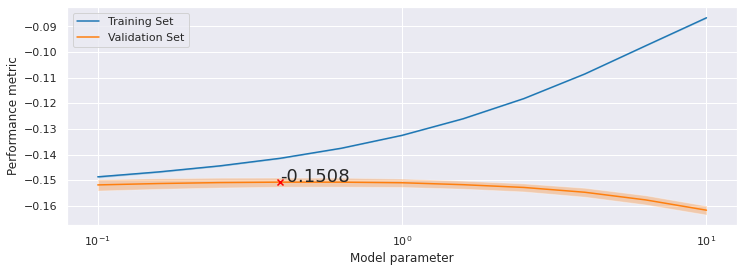

In [70]:
df_pred, pred_tr, pred_te, grid, y_tr = run_prediction(
    model_metric, estimator=estimator, alphas=Cs, cv=cv,
    scaler_targets=scaler_targets, target=target, tidx=tidx,
    scale_values=scale_values)

In [71]:
# Save predictions for age in output variable
predictions_svr[target] = pred_te

## 6.3. Predicting `domain1_var2` using SVR(rbf)

In [72]:
# Select the target (name and index)
target = 'domain1_var2'
tidx = 2

In [73]:
# Let's select which features to use and how to scale them
scale_values = [0.18,      # Feature: IC
                0.01,      # Feature: FNC
                np.nan,    # Feature: Intra Corr (no improvement)
                0.025,     # Feature: Inter Corr
               ]

In [74]:
# Define model parameters
estimator = SVR(gamma='scale', epsilon=0.2, tol=1e-3, max_iter=5000)
Cs = np.logspace(-1.5, 0.5, 11)
cv = 5

Removing 437 missing values from target dataset.
Size of dataset (train/test):  (5398, 2782) (5877, 2782)
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed: 42.4min finished


Dataset scales used:  [0.18, 0.01, nan, 0.025]
Best score at: -0.150578 using {'estimator__C': 0.19952623149688797}


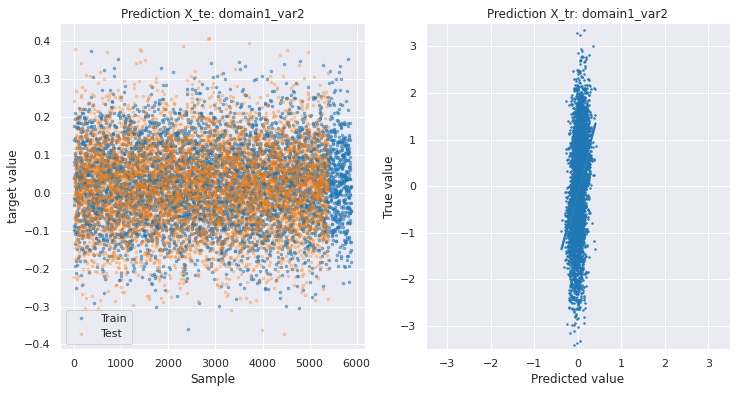

,param_estimator__C,mean_test_score,std_test_score,mean_train_score,std_train_score
4,0.199526,-0.150578,0.003674,-0.143941,0.000873
3,0.125893,-0.150608,0.003685,-0.146156,0.000879
5,0.316228,-0.150658,0.003623,-0.140906,0.000866
2,0.079433,-0.150705,0.003641,-0.147730,0.000893
1,0.050119,-0.150803,0.003611,-0.148812,0.000896


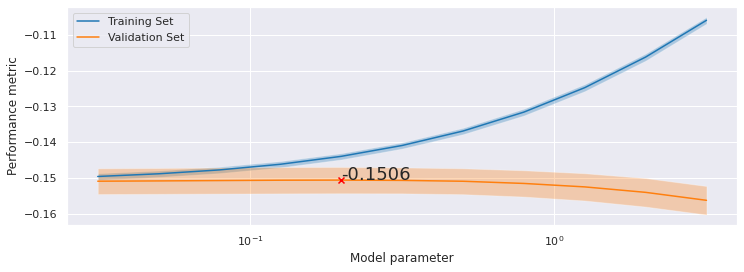

In [75]:
df_pred, pred_tr, pred_te, grid, y_tr = run_prediction(
    model_metric, estimator=estimator, alphas=Cs, cv=cv,
    scaler_targets=scaler_targets, target=target, tidx=tidx,
    scale_values=scale_values)

In [76]:
# Save predictions for age in output variable
predictions_svr[target] = pred_te

## 6.4. Predicting `domain2_var1` using SVR(rbf)

In [77]:
# Select the target (name and index)
target = 'domain2_var1'
tidx = 3

In [78]:
# Let's select which features to use and how to scale them
scale_values = [0.25,      # Feature: IC
                0.025,     # Feature: FNC
                0.036,     # Feature: Intra Corr (no improvement)
                0.023,     # Feature: Inter Corr
               ]

In [79]:
# Define model parameters
estimator = SVR(gamma='scale', epsilon=0.2, tol=1e-3, max_iter=5000)
Cs = np.logspace(-1, 1, 11)
cv = 5

Removing 39 missing values from target dataset.
Size of dataset (train/test):  (5796, 2835) (5877, 2835)
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed: 48.8min finished


Dataset scales used:  [0.25, 0.025, 0.036, 0.023]
Best score at: -0.180495 using {'estimator__C': 0.3981071705534973}


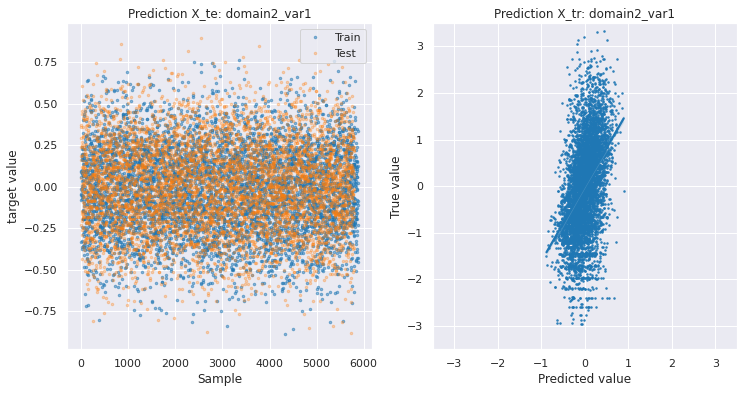

,param_estimator__C,mean_test_score,std_test_score,mean_train_score,std_train_score
3,0.398107,-0.180495,0.004051,-0.165761,0.000921
2,0.251189,-0.180533,0.004095,-0.170344,0.000952
1,0.158489,-0.180808,0.004163,-0.173811,0.000980
4,0.630957,-0.180866,0.003932,-0.159758,0.000875
0,0.100000,-0.181295,0.004129,-0.176562,0.001010


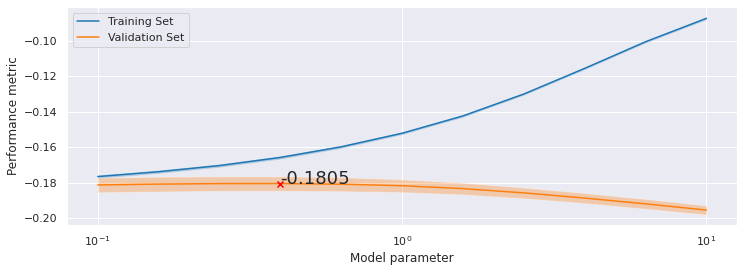

In [80]:
df_pred, pred_tr, pred_te, grid, y_tr = run_prediction(
    model_metric, estimator=estimator, alphas=Cs, cv=cv,
    scaler_targets=scaler_targets, target=target, tidx=tidx,
    scale_values=scale_values)

In [81]:
# Save predictions for age in output variable
predictions_svr[target] = pred_te

## 6.5. Predicting `domain2_var2` using SVR(rbf)

In [82]:
# Select the target (name and index)
target = 'domain2_var2'
tidx = 4

In [83]:
# Let's select which features to use and how to scale them
scale_values = [0.189,      # Feature: IC
                0.025,      # Feature: FNC
                0.050,    # Feature: Intra Corr (no improvement)
                0.022,     # Feature: Inter Corr
               ]

In [84]:
# Define model parameters
estimator = SVR(gamma='scale', epsilon=0.2, tol=1e-3, max_iter=5000)
Cs = np.logspace(-1, 1, 11)
cv = 5

Removing 39 missing values from target dataset.
Size of dataset (train/test):  (5796, 2835) (5877, 2835)
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed: 47.9min finished


Dataset scales used:  [0.189, 0.025, 0.05, 0.022]
Best score at: -0.175094 using {'estimator__C': 0.251188643150958}


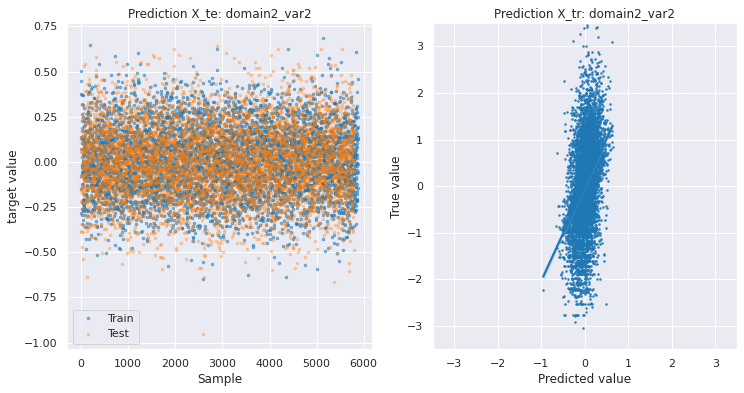

,param_estimator__C,mean_test_score,std_test_score,mean_train_score,std_train_score
2,0.251189,-0.175094,0.003300,-0.163855,0.000913
1,0.158489,-0.175193,0.003187,-0.167473,0.000876
3,0.398107,-0.175353,0.003441,-0.159084,0.000968
0,0.100000,-0.175548,0.003186,-0.170238,0.000837
4,0.630957,-0.176026,0.003684,-0.152798,0.000975


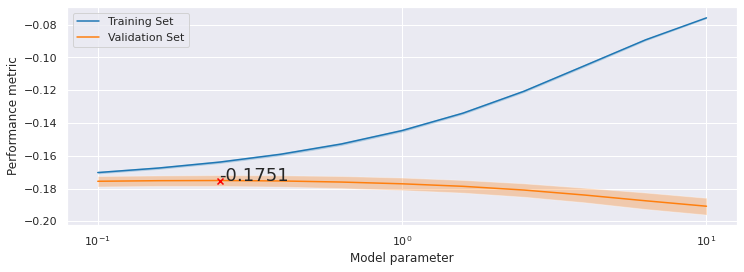

In [85]:
df_pred, pred_tr, pred_te, grid, y_tr = run_prediction(
    model_metric, estimator=estimator, alphas=Cs, cv=cv,
    scaler_targets=scaler_targets, target=target, tidx=tidx,
    scale_values=scale_values)

In [86]:
# Save predictions for age in output variable
predictions_svr[target] = pred_te

# 7. Saving predictions

In [87]:
# Load sample submission file
submission = pd.read_csv(opj('/kaggle', 'input', 'trends-assessment-prediction', 'sample_submission.csv')).set_index('Id')
submission.head()

,Predicted
Id,
10003_age,50.0
10003_domain1_var1,50.0
10003_domain1_var2,50.0
10003_domain2_var1,50.0
10003_domain2_var2,50.0


Let's write a function that inverts the initial target feature adapataions (i.e. scaling and power transformation).

In [88]:
def back_transform(y_test, unique_values, scaler=None, tidx=0):
    
    # List of power transformations
    pow_age = 1.0
    pow_d1v1 = 1.5
    pow_d1v2 = 1.5
    pow_d2v1 = 1.5
    pow_d2v2 = 1.5
    pow_d21 = 1.5
    pow_d22 = 1.0

    powers = [pow_age, pow_d1v1, pow_d1v2, pow_d2v1, pow_d2v2, pow_d21, pow_d22]
    
    # Assign closest value from training set
    for i, a in enumerate(y_test):
        y_test[i] = unique_values[np.argmin(np.abs(a-unique_values))]
    
    # Invert scaler
    y_test = scaler.inverse_transform(np.transpose([y_test] * 7))[:, tidx]
    
    # Invert power transformation
    y_test = np.power(y_test, 1./powers[tidx])

    return y_test

In [89]:
# Fill up the submission file with the ridge predictions
prediction_dict = predictions_ridge
for i, t in enumerate(['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']):
    unique_values = sorted(targets[t].dropna().unique())
    pred_values = back_transform(prediction_dict[t], unique_values, scaler=scaler_targets, tidx=i)
    submission.iloc[submission.index.str.contains(t), 0] = pred_values

# Let's visualize a few points from the submission file
display(submission.head(10))

# Store predictions in CSF file
submission.to_csv('submission_ridge.csv')

,Predicted
Id,
10003_age,55.456978
10003_domain1_var1,49.959973
10003_domain1_var2,59.575877
10003_domain2_var1,49.001714
10003_domain2_var2,57.788997
10006_age,66.532630
10006_domain1_var1,55.778774
10006_domain1_var2,60.031696
10006_domain2_var1,49.301810


### Score for pure Ridge model

Only using the predictions from the Ridge model, we would have reached a score of 0.15808, which in the final rating would have lead to the 24th place in the public leaderboard.

**Note**: Out of interest, I also ran the predcition with the "feature offset correction" described by the 1st place team (see [here](https://www.kaggle.com/c/trends-assessment-prediction/discussion/163017), which moved the score of the Ridge model to 0.15787, corresponding to the 21st position on the public leaderboard.

In [90]:
# Fill up the submission file with the ridge predictions
prediction_dict = predictions_svr
for i, t in enumerate(['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']):
    unique_values = sorted(targets[t].dropna().unique())
    pred_values = back_transform(prediction_dict[t], unique_values, scaler=scaler_targets, tidx=i)
    submission.iloc[submission.index.str.contains(t), 0] = pred_values

# Let's visualize a few points from the submission file
display(submission.head(10))

# Store predictions in CSF file
submission.to_csv('submission_svr.csv')

,Predicted
Id,
10003_age,51.996514
10003_domain1_var1,50.383948
10003_domain1_var2,61.320488
10003_domain2_var1,48.614769
10003_domain2_var2,57.644548
10006_age,64.203107
10006_domain1_var1,55.356905
10006_domain1_var2,59.453418
10006_domain2_var1,49.001714


### Score for pure SVR model

Only using the predictions from the SVR model, we would have reached a score of 0.15769, which in the final rating would have lead to the 19th place in the public leaderboard.


**Note**: Out of interest, I also ran the predcition with the "feature offset correction" described by the 1st place team (see [here](https://www.kaggle.com/c/trends-assessment-prediction/discussion/163017), which moved the score of the SVR model to 0.15738, corresponding to the 13th position on the public leaderboard.

# 8. Visualize differences in prediction

As a final last step, let's also look at the prediction differences between the two models.

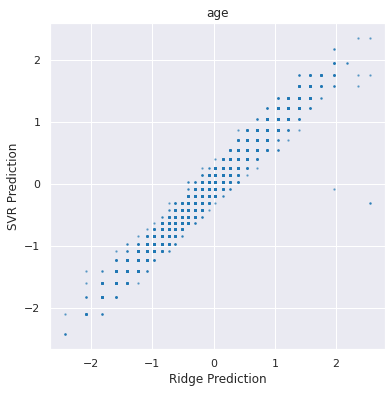

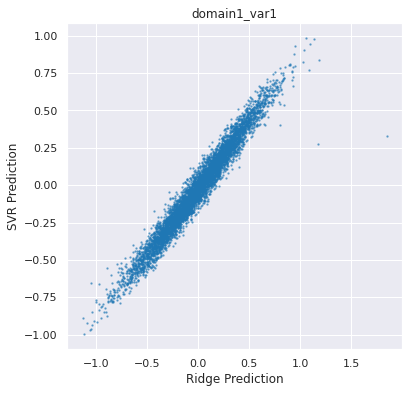

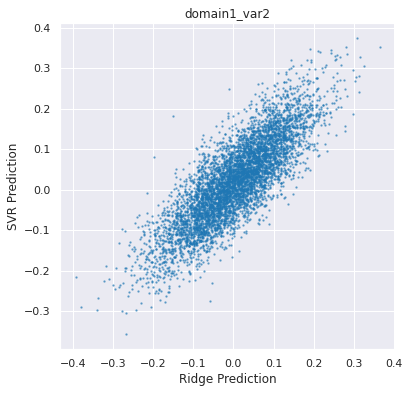

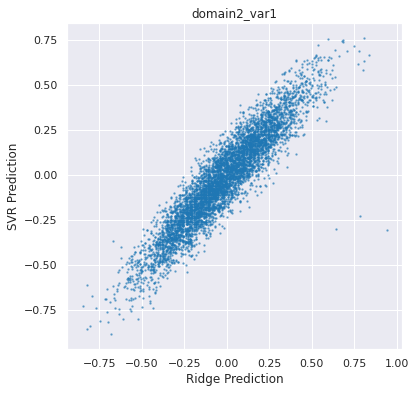

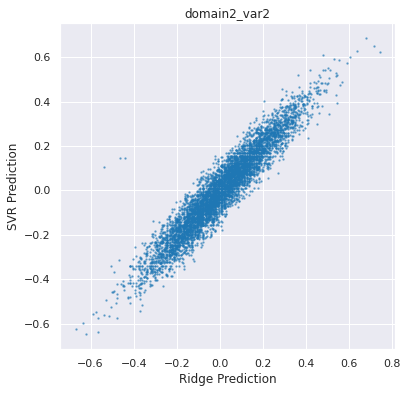

In [91]:
for c in predictions_ridge.keys():
    plt.figure(figsize=(6, 6))
    plt.scatter(predictions_ridge[c], predictions_svr[c], s=2, alpha=0.5)
    plt.title(c)
    plt.xlabel('Ridge Prediction')
    plt.ylabel('SVR Prediction')
    plt.show()